# Input Representations

In this notebook, we'll see various audio input representations that are used for music classification. The end-to-end learning of neural networks start with an input representation.

This is an important design choices that music/audio researchers should make as opposed to people in natural language processing or computer vision. Why? Because the optimal choice of audio input representations is more difficult than in other domains as you'll see here.

Let's get started! 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd


plt.rcParams.update({'font.size': 16, 'axes.grid': True})

SR = 22050  # sample rate of audio
wide = (18, 3)  # figure size
big = (18, 8)  # figure size

print(f"{librosa.__version__=}")

librosa.__version__='0.8.1'


In [12]:
src, sr = librosa.load('are-you-here-with-me(mono).mp3', sr=SR, mono=True, duration=5.0)

print(f'{src.shape=}, {sr=}')

/Users/admin/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


src.shape=(110250,), sr=22050


# Waveforms

```{note}
Waveforms are records of amplitudes of audio signals.
```

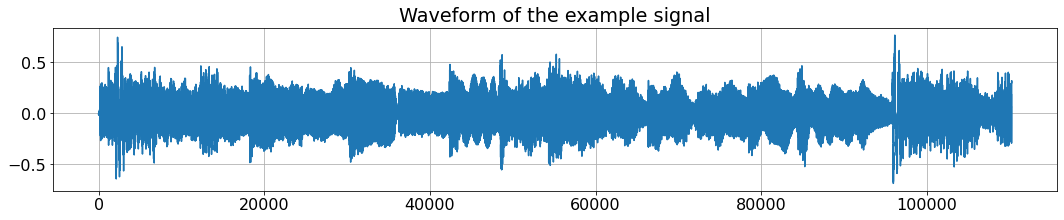

In [13]:
plt.figure(figsize=wide)  # plot using matplotlib
plt.title('Waveform of the example signal')
plt.plot(src);

In [14]:
ipd.Audio(src, rate=sr) # load a NumPy array

Effective visualization of audio representations is trickier than you think. FYI, you can ask `librosa` to take care of it as below. We'll get back to this civilization once we play with it from scarch enough. 

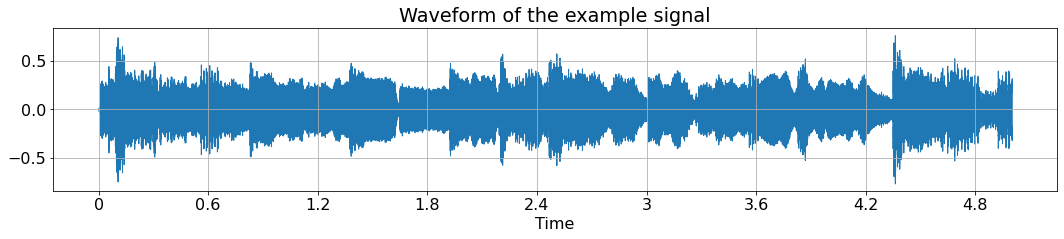

In [15]:
plt.figure(figsize=wide)  # plot using librosa
plt.title('Waveform of the example signal')
librosa.display.waveshow(src, sr=22050);

Let's zoom into the waveform.

(-0.5, 0.5)

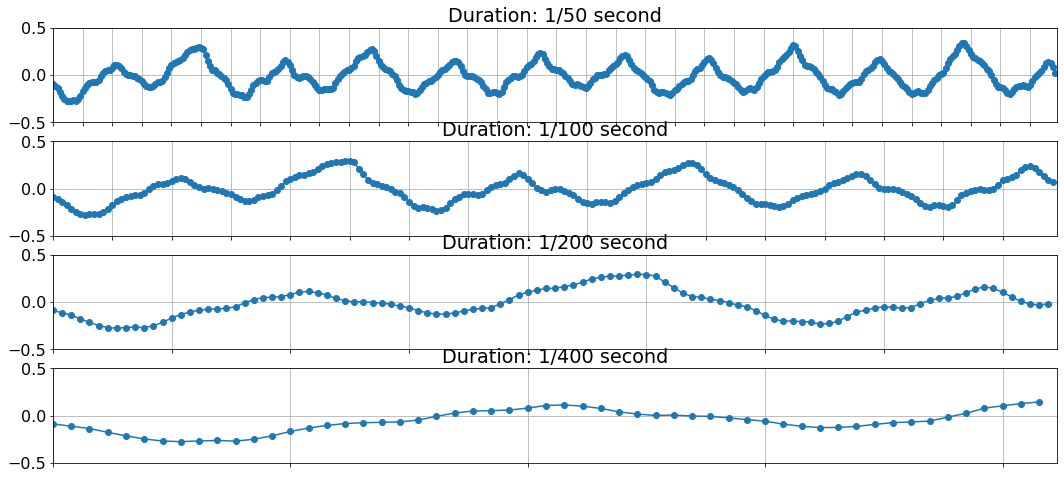

In [16]:
plt.figure(figsize=big)
plt.subplot(4, 1, 1)
plt.plot(src[10000:10000 + SR // 50], marker='o')
plt.title('Duration: 1/50 second'); plt.xlim([0, SR // 50]); plt.xticks(range(0, SR // 50, SR // 50 // 32), [])
plt.ylim([-0.5, 0.5])

plt.subplot(4, 1, 2)
plt.plot(src[10000:10000 + SR // 100], marker='o')
plt.title('Duration: 1/100 second'); plt.xlim([0, SR // 100]); plt.xticks(range(0, SR // 100, SR // 50 // 32), [])
plt.ylim([-0.5, 0.5])

plt.subplot(4, 1, 3)
plt.plot(src[10000:10000 + SR // 200], marker='o')
plt.title('Duration: 1/200 second'); plt.xlim([0, SR // 200]); plt.xticks(range(0, SR // 200, SR // 50 // 32), [])
plt.ylim([-0.5, 0.5])

plt.subplot(4, 1, 4)
plt.plot(src[10000:10000 + SR // 400], marker='o')
plt.title('Duration: 1/400 second'); plt.xlim([0, SR // 400]); plt.xticks(range(0, SR // 400, SR // 50 // 32), [])
plt.ylim([-0.5, 0.5])

This 5-second 22,050-Hz sampled mono audio has a shape of `(110250, )`. So, what is this long 1-dimensional array? It is a representation for (diaphragms of) speakers, whose goal is to produce the sound (the change of pressure in the air) correctly.
As the raw end of audio signals, waveforms were used as input of music classification models in [**[DS14]**](https://ieeexplore.ieee.org/abstract/document/6854950), [**[LPK+17]**](https://arxiv.org/abs/1703.01789), etc.

Is waveform the best representation for neural networks? It depends. So far, for analysis purposes, it's okay, not quite the best. 

  - If you have a lot of data, it's worth trying with the minimally assuming, waveform-based models such as Sample-CNN ([**[LPK+17]**](https://arxiv.org/abs/1703.01789)). But beware, it's requires large memory, lots of computation, and large-scale data.

Then, what is the best representation? There is no single answer to the question. 

  - Melspectrogram has been very popular for practical reasons. The performance is strong, its memory usage is small, and the computation is simple. This is probably everyone's go-to choice.
  - Constant-Q Transform (CQT) is quite similar to Melspectrogram for ML models. However, it is more computation heavy and is less available in softwares we use.
  - STFT has some good properties but its size is usually bigger than Melspectrograms or CQT. 

  
Ok. But, what are they?

# Spectrograms: time-frequency representations

The amplitudes are what our eardrums respond to. It is then converted to a sort of 2-dimensional representation in our cochlear. In other words, we do some sort of frequency analysis in our auditory system. 
This means that 2-dimensioal representations are biologically plausible.


Additionally, spectrograms have been a neural network-friendly representation because they fit well with properties of some popular architectures. For example, local correlation and the shift invariance of CNNs can be utilized nicely when we're using spectrograms such as STFT, melspectrograms, or constant-Q transform (CQT).

But what is a spectrogram? 

```{note}
Spectrogram refers to a (2D) visualization of sound. 
```

Let's take a look at STFT first.

## STFT

STFT (short-time Fourier transform) is the most "raw" kind of spectrograms
  - We can fully reconstruct the audio signal from a STFT. 
  - It has a linear frequency resolution spans from 0 Hz (DC component) to (sample rate) / 2 Hz (aka Nyquist frequency). 
  - STFT consists of complex numbers.
    - **Modification 1**: However, for analysis purposes, we usually use its magnitudes. This is biologically plausible since [the human auditory system is insensitive to phase information].(https://ptolemy.berkeley.edu/eecs20/week8/phase.html).
    
In papers and such, STFT usually refers to the magnitude of STFT while the original, complex-numbered STFT is referred as "complex STFT" or something like that.

stft_complex.dtype=dtype('complex64')
stft_complex.shape=(257, 862)
stft_complex[3, 3]=(-0.9134862+0.22103079j)

stft.dtype=dtype('float32')
stft.shape=(257, 862)
stft[3, 3]=0.9398466



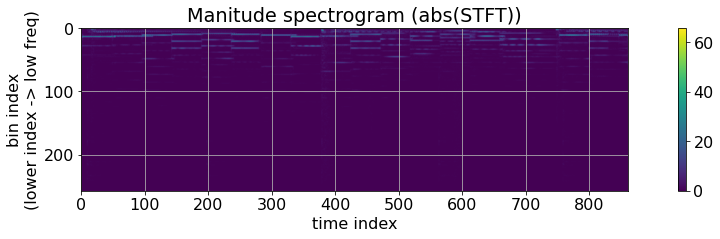

In [17]:
n_fft = 512
hop_length = n_fft // 4
stft_complex = librosa.stft(y=src, n_fft=n_fft, hop_length=hop_length)
print(f"{stft_complex.dtype=}\n{stft_complex.shape=}\n{stft_complex[3, 3]=}\n")

stft = np.abs(stft_complex)
print(f"{stft.dtype=}\n{stft.shape=}\n{stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(stft)
plt.colorbar(img)
plt.ylabel('bin index\n(lower index -> low freq)');plt.xlabel('time index')
plt.title('Manitude spectrogram (abs(STFT))');

Can you see the slight activations on the lower frequency (near the upper boundary)? That's the magnitudes of the STFT of our example signal. But this looks sparse!

Let's time-average the frequency distribution and plot it.

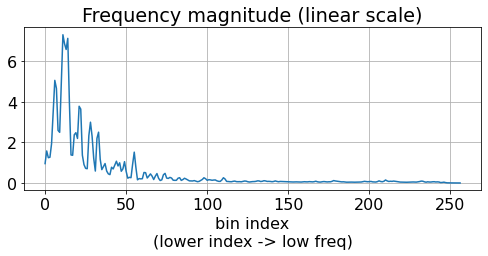

In [18]:
stft_freq_distritubion = np.mean(stft, axis=1)
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
plt.plot(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.title('Frequency magnitude (linear scale)');

This is quite a long-tail, and that's why the spectrogram above didn't seem very clear for us. 
And even worse, this kind of extreme distribution is not good for neural networks. 

That's why we usually take `log()` to magnitude spectrograms. Let's first compare their distributions.

- **Modification 2** After `abs()`, we compress it with `log()`. This is also biologically plausible - human perception is loudness is much closer to the logarithm scale than a linear scale (i.e., it follows Weber–Fechner law)
  

(You can find more discussion on this in [**[CFC+2018a]**](https://arxiv.org/abs/1709.01922).)

Text(0.5, 1.0, 'Frequency magnitude (log scale)')

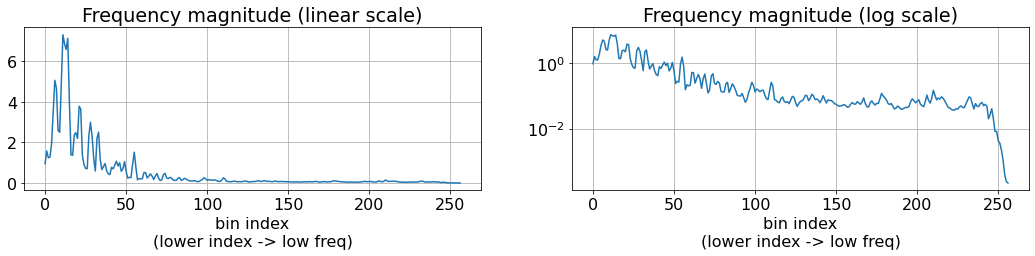

In [19]:
stft_freq_distritubion = np.mean(stft, axis=1)
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
plt.plot(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.title('Frequency magnitude (linear scale)')

plt.subplot(1, 2, 2)
plt.semilogy(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.title('Frequency magnitude (log scale)')


```{note}
By "STFT" in deep learning-related articles, people often mean log-magnitude STFT.
```

Let me show you this!

log_stft.dtype=dtype('float32')
log_stft.shape=(257, 862)
log_stft[3, 3]=-0.060975205



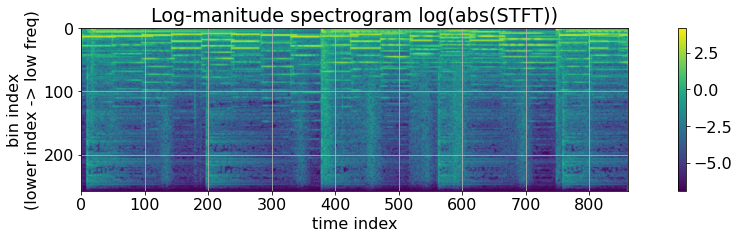

In [20]:
epsilon = 0.001
log_stft = np.log(np.abs(stft_complex) + epsilon)
print(f"{log_stft.dtype=}\n{log_stft.shape=}\n{log_stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(log_stft)
plt.colorbar(img)
plt.ylabel('bin index\n(lower index -> low freq)');plt.xlabel('time index')
plt.title('Log-manitude spectrogram log(abs(STFT))')

ipd.Audio(src, rate=sr) # load a NumPy array

The essence of this logarithm mapping (or compression) of magnitudes is to use the nonlinear curve of `log(x)` where `x > 1`. 

<ipython-input-53-c9b099bf056a>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(xs[:10], np.log10(xs[:10]), c='blue', alpha=0.3)


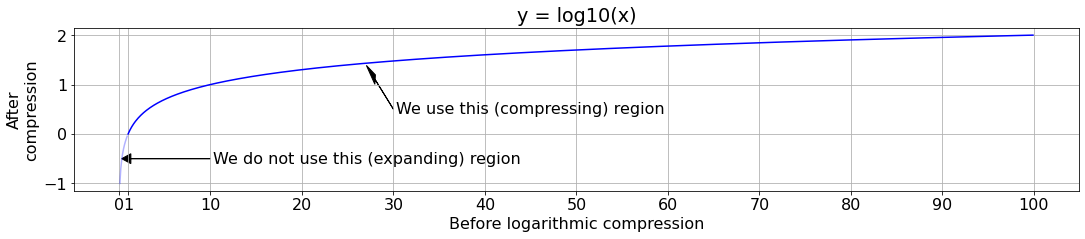

In [53]:
xs = np.arange(0, 100, 0.1)
plt.figure(figsize=wide)
plt.plot(xs[:10], np.log10(xs[:10]), c='blue', alpha=0.3)
plt.plot(xs[10:], np.log10(xs[10:]), c='blue')
plt.xticks([0, 1] + list(range(10, 101, 10)))


plt.arrow(10, -0.5, -8.7, 0, head_width=0.2, head_length=1.0, fc='k', ec='k')
plt.text(10.3, -0.5, "We do not use this (expanding) region", va='center')

plt.arrow(30, 0.5, -2, 0.6, head_width=0.2, head_length=1, fc='k', ec='k')
plt.text(30.3, 0.5, "We use this (compressing) region", va='center')

plt.xlabel('Before logarithmic compression')
plt.ylabel('After\ncompression')
plt.title('y = log10(x)');

This is exactly what's happening in [Decibel scaling](https://en.wikipedia.org/wiki/Decibel). Decibel scaling is also logarithm mapping but with a few different choices of the constants (e.g., log10 vs log, etc) so that 0 dB becomes absolute silence and 130 dB becomes a really really loud sound. Check out the implementations in [`librosa.amplitude_to_db()`](https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html) and [`librosa.power_to_db()`](https://librosa.org/doc/main/generated/librosa.power_to_db.html) for more correct and  numerically stable and decibel scaling.

Finally, it doesn't look so right when low-frequency is at the top of the image. Let's flip up-down to correct it.

In [54]:
epsilon = 0.001
log_stft = np.log(np.abs(stft_complex) + epsilon)
log_stft = np.flipud(log_stft)  # <-- Here! The rest of the code is hidden.

log_stft.dtype=dtype('float32')
log_stft.shape=(257, 862)
log_stft[3, 3]=-6.8234167



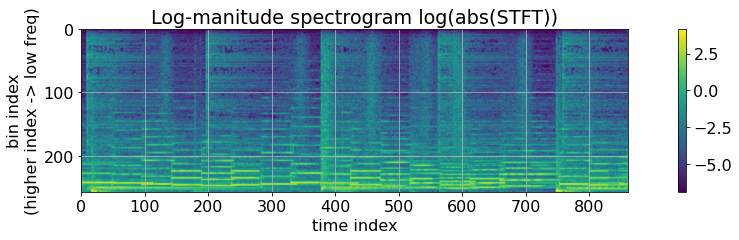

In [55]:
print(f"{log_stft.dtype=}\n{log_stft.shape=}\n{log_stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(log_stft)
plt.colorbar(img)
plt.ylabel('bin index\n(higher index -> low freq)');plt.xlabel('time index')
plt.title('Log-manitude spectrogram log(abs(STFT))');

OK! This is the famous log-magnitude STFT. Quite often, people call it simply a STFT or a log-STFT. 

From here, I'll use `libros` more actively because i) the implementation of other representations is not trivial and ii) so that the x- and y-axes are nicely displayed in more convenient units.

Additionally, it's always safe to make your data zero-centered. That's also done quite nicely with the default parameters of `librosa`. 

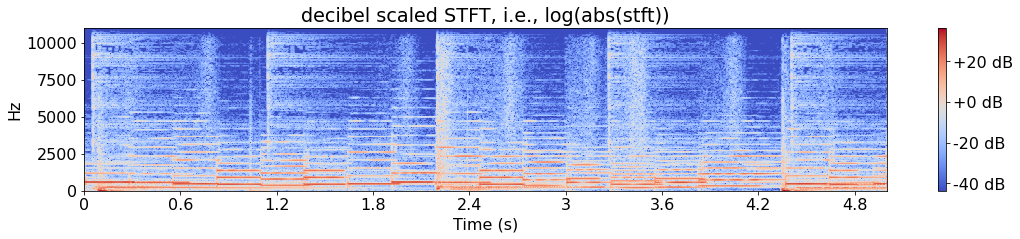

In [60]:
plt.figure(figsize=wide)
img = librosa.display.specshow(librosa.amplitude_to_db(stft), sr=SR, x_axis='s', y_axis='linear', hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('decibel scaled STFT, i.e., log(abs(stft))');

## Even more modifications? 

By computing log(abs(STFT)), we get a nice image of the sound. But, it is just a beginning! 


### Reasons for modifying the frequency scale
 - Our perception of frequency is also nonlinear (approximately.. (drum rolls!..) logarithmic).
 - Similarly, we defined pitches in the octave (=logarithmic) scale

### Reasons why it's okay to remove some high frequency bands
 - The highest frequency of original audio signals is usually 22kHz which is pretty far beyond our range. 
 - Similarly, the information in high-frequency ranges (e.g., f > 10kHz) is i) sparse, ii) not that necessary for most of MIR tasks, and iii) barely audible for us.

### Reason why, then, it's better to remove some high frequency bands
 - Because we want to remove any redundant memory and computation especially in deep leanring.


Because of these, researchers have been using time-frequency representations that are modifications of log(abs(STFT)). 

## Melspectrograms

Melspectrograms have been the top choices for music tagging and classification. But what is a melspectrogram?

Melspectrogram is a result of converting the linear frequency scale into the *mel scale*. There are many similar but different formula to compute it, but it's *kinda like* log-scale. 

**Benefits**
- It's reduces the number of frequency band greatly. For example, 1028 -> 128. What a deep learning-plausible number it becomes!
- It's simple and fast - the computation is a matrix multiplication of a pre-computed filterbank matrix.
- It's effective - the model works even better in many cases.

In [58]:
log_melgram = librosa.power_to_db(
    np.abs(
        librosa.feature.melspectrogram(src, sr=SR, n_fft=n_fft, hop_length=hop_length, power=2.0)
    )
)

Text(0.5, 1.0, 'log(melspectrogram)')

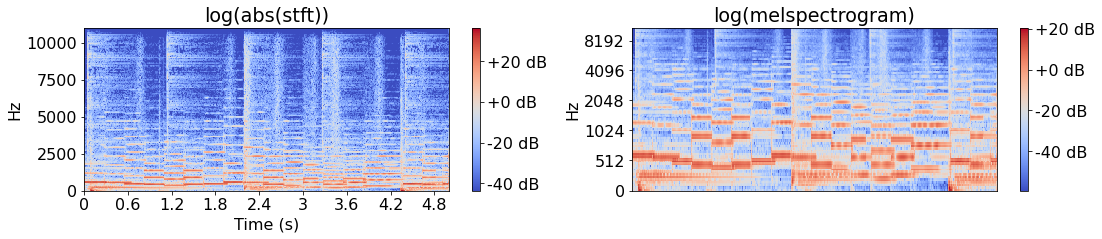

In [62]:
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
img = librosa.display.specshow(librosa.amplitude_to_db(stft), sr=SR, x_axis='s', y_axis='linear', hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(abs(stft))')

plt.subplot(1, 2, 2)
img = librosa.display.specshow(log_melgram, y_axis='mel', sr=SR, hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(melspectrogram)')

## Constant-Q Transform

As we've seen, melspectrograms are great! But it is just a simple aggregation of high-frequency bins into one. This means the frequency resolution of melspectrogram is bound by that of STFT. And there is always a trade-off between time and frequency resolutions in STFT. 

Constant-Q Transform is more radical. Why not having accurately octave scale representation? 

Its implementation is not trivial, but the idea is to use time-varying windows for different center frequency. Let's see the result.

In [63]:
log_cqt = librosa.amplitude_to_db(
    np.abs(
        librosa.cqt(src, sr=SR, hop_length=hop_length, n_bins=24*7, bins_per_octave=24, fmin=librosa.note_to_hz('C1'))
    )
)

Text(0.5, 1.0, 'log(cqt)')

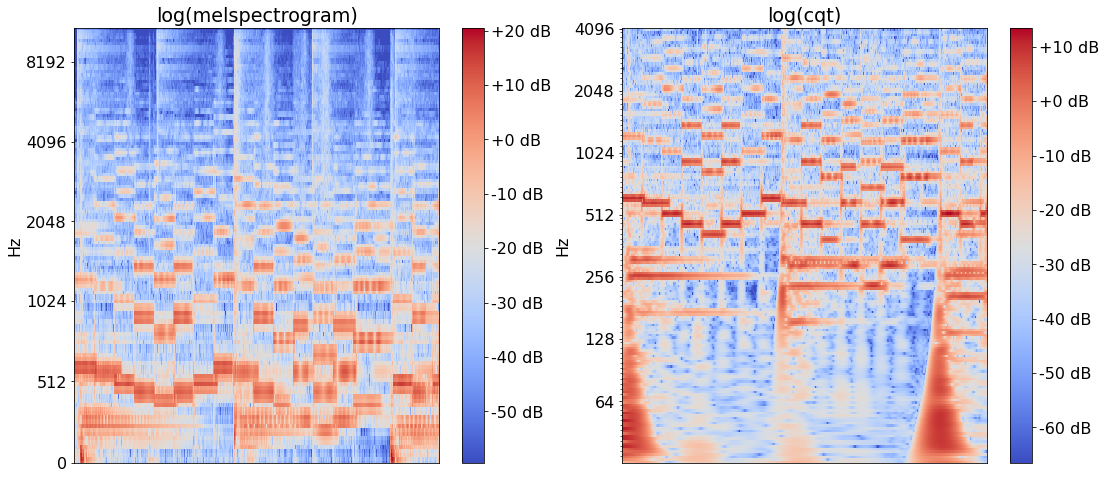

In [64]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
img = librosa.display.specshow(log_melgram, y_axis='mel', sr=SR, hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(melspectrogram)')

plt.subplot(1, 2, 2)
img = librosa.display.specshow(log_cqt, y_axis='cqt_hz', sr=SR, hop_length=hop_length, bins_per_octave=24)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(cqt)')

The difference is pretty obvious here - we get a much better pitch resolution!

# Practical Issue: How to compute them?

There are several softwares that computes these representations. Take this information with a grain of salt because it will be outdated after releasing this book (2021 Nov).


### Waveforms

First of all, you get waveforms by simply loading the audio.
  - You'd need an audio codec (e.g., FFMPEG) if your audio comes in formats such as mp3, m4a, aac, or ogg. 
    - Usually, your audio file loader returns a floating-point data array where the amplitude is in `[-1.0, 1.0]`. But, the original `wav` file usually stores the amplitudes in `int16` format. (No worries though, `Float32` is precise enough to represent them.)
  - You can use [`scipy.io.wavfile.read`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) to load PCM audio. 

### Spectrograms

There are various softwares and approaches to compute STFT, melspectrogram, and CQT.
  - On CPU
    - **librosa**: [librosa.stft](https://librosa.org/doc/latest/generated/librosa.stft.html) internally uses `stft` but with a more tailored and carefully chosen API with default values. It also includes functions to compute a [melspectrogram](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) and a [CQT](https://librosa.org/doc/latest/generated/librosa.cqt.html). 
    - **scipy**: [scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) is a cpu-based implementation of STFT using FFT.
    
  - On CPU & GPU
    - **Torchaudio**: One can compute STFT using [`torchaudio.functional.spectrogram`](https://pytorch.org/audio/stable/functional.html#spectrogram). It also includes a wide variety of functions and utilities such as [`amplitude_to_DB`](https://pytorch.org/audio/stable/functional.html#amplitude-to-db) and [`resampling`](https://pytorch.org/audio/stable/functional.html#resample).
    - **nnAudio**: It has multiple versions of [CQT computation functions](https://kinwaicheuk.github.io/nnAudio/_autosummary/nnAudio.Spectrogram.html) as well as others e.g., STFT and melspectrogram. Its STFT computation is based on Conv1D, not FFT. 
    - **Tensorflow**: It has a native support of [stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft). However, [it is slow on cpu](https://github.com/tensorflow/tensorflow/issues/6541), which might be critical if your model is going to be deployed on cpu-only machines. It, by the way, even has a [function to convert an STFT to melspectrogram](https://www.tensorflow.org/api_docs/python/tf/signal/linear_to_mel_weight_matrix).
    - **kapre**: [kapre.time_frequency](https://kapre.readthedocs.io/en/latest/time_frequency.html) includes `tf.keras` layers such as STFT and melspectrogram as well as utilities as decibel conversion. Its STFT layer is a wrapper of `tf.signal.stft`.


### Consistency between softwares

Not all the implementations are equal! Especially.. everything. 

  - Default behavior such as padding may be different
  - There is no single canonical reference implementation of some concepts such as mel scale.
  - CQT is an approximation yet. There is no method to compute CQT with perfect reconstruction.

One should make sure that all the data are processed consistently. The easiest way is to have a single method that process all the data during training and after deployment. This may be tricky, but possible for most of the cases. See the comparisons and suggestions linked below for more information.

  - [Librosa and Scipy](https://gist.github.com/bmcfee/746e572232be36f3bd462749fb1796da)
  - [Librosa and Tensorflow](https://colab.research.google.com/drive/1ptS1UkpHa-dW8w7WEf8xTE63mEQg8NQZ)
  - [Librosa and Torchaudio](https://github.com/pytorch/audio/issues/1058#issuecomment-778476093)
  
